In [1]:
import pandas as pd
import sqlite3
import os
from functools import wraps
from datetime import datetime
import matplotlib.pyplot as plt

# Objetivo do notebook

Este notebook tem por objetivo responder às questões enviadas para o desafio, registrando de forma compreensível por humanos a metodologia e os processamentos que serão implementados nos endpoints da API.

Também registraremos aqui a resposta à última questão, que, conforme instruções enviadas, deve ser respondida separadamente, não entrando no escopo da API.

#### Carregando os dados

Nas células a seguir carregaremos os dados gerados pelo ETL (ver notebook "etl_dados_para_sqlite.ipynb")

In [2]:
path_dados = os.path.abspath(os.path.join('data', 'desafio_selecao.db'))
con = sqlite3.connect(path_dados)

In [3]:
df = pd.read_sql('SELECT * FROM respostas_diagnostico', con)

In [4]:
con.close()

In [5]:
df.head()

,id_resposta,ano_diagnostico,data_submissao,orgao,tipo_orgao,qtd_equipe,utiliza_metodologia,desktop_proprio,desktop_locado,desktop_proprio_antigo
0,5,2017,2017-04-20 10:39:54,SUBPR,Subprefeitura,3.0,0.0,152,0,107
1,8,2019,2019-04-12 10:55:24,SMS,Secretaria,58.0,0.0,12500,0,6927.0000000000
2,9,2019,2019-04-05 15:57:10,SUBSA,Subprefeitura,3.0,NaN,36,90,0.0000000000
3,10,2017,2017-05-17 09:13:17,IPREM,Administração Indireta,6.0,0.0,200,0,0
4,10,2019,2019-03-25 14:40:06,SUBST,Subprefeitura,3.0,NaN,150,0,150.0000000000


In [6]:
len(df)

307

In [7]:
df.dtypes

id_resposta                 int64
ano_diagnostico             int64
data_submissao             object
orgao                      object
tipo_orgao                 object
qtd_equipe                float64
utiliza_metodologia       float64
desktop_proprio            object
desktop_locado             object
desktop_proprio_antigo     object
dtype: object

Algumas colunas que parecem ser float vieram como text, mas isso está de acordo com o schema e com o dicionário de variáveis.

É possível que tenhamos que tratar isso, no entanto, para responder alguma das questões.

### Filtrando pela data de reposição

Conforme orientações:

> É importante ressaltar também que o campo data_submissao é preenchido apenas quando o formulário é efetivamente concluído e aceito. Por isso, considere somente as respostas que possuam o campo data_submissao preenchido!

In [8]:
sem_data = df['data_submissao'].isnull()

In [9]:
sem_data.mean()

0.34527687296416937

Aproximadamente 30% das respostas nao possui data de submissao

In [10]:
df[sem_data].sample(5)

,id_resposta,ano_diagnostico,data_submissao,orgao,tipo_orgao,qtd_equipe,utiliza_metodologia,desktop_proprio,desktop_locado,desktop_proprio_antigo
237,329,2017,None,None,None,NaN,NaN,None,None,None
300,394,2017,None,None,None,NaN,NaN,None,None,None
223,313,2017,None,None,None,NaN,NaN,None,None,None
212,302,2017,None,A25,None,0.0,0.0,None,None,None
248,340,2017,None,None,None,NaN,NaN,None,None,None


Como podemos ver, os formulário sem data de submissão vieram de fato incompletos.

Vamos inserir portanto esse filtro na função de obtenção dos dados, para garantir que ele seja sempre realizado.

In [11]:
def get_data():
    
    path_dados = os.path.abspath(os.path.join('data', 'desafio_selecao.db'))
    con = sqlite3.connect(path_dados)
    
    df = pd.read_sql('SELECT * FROM respostas_diagnostico WHERE data_submissao NOT NULL', 
                     con)
    
    return df

In [12]:
df = get_data()

In [13]:
assert df['data_submissao'].notnull().all()

Como diversas questões utilizam o parâmetro ano, vamos criar um decorator para limpar esse dado e levantar erros semânticos caso o parâmetro seja imputado incorretamente (por exemplo, caso seja um ano não compreendido na pesquisa).

O mesmo será feito para o parametro secretaria.

Além disso, vamos fazer uma função para sempre copiar o dataframe, evitando que ele seja modificado globalmente.

Como os dados são pequenos, isso nos permitirá fazer uma otimização na API, colocando os dados in memory e apenas copiando o objeto dataframe de thread a thread da API. Isso nos permitirá evitar fazer a leitura dos dados (que é uma ação de I.O. um pouco mais lenta). Note que isso é recomendado apenas para casos como esse, em que a quantidade de dados é pequena. Em outros casos, o ideal é fazer a leitura dos dados a cada chamada de API, e implementar algum tipo de cache.

In [14]:
def solve_ano(func):
    '''
    Solves the ano param, raising appropriated errors.
    Decorated func must have one keyword arguments named
    ano. Also, df should be the first positional argument'''
    
    @wraps(func)
    def decorated(*args, **kwargs):
        
        if len(args)<1:
            df = kwargs['df']
        else:
            df =  args[0]
        ano = kwargs.pop('ano')
        try:
            ano = int(ano)
            kwargs['ano'] = ano
        except ValueError:
            raise ValueError('Param <ano> must be integer, float or a string convertible to int')

        if ano not in df['ano_diagnostico'].unique():
            raise NotImplementedError(f'Ano {ano} não compreendido na pesquisa')
            
        return func(*args, **kwargs)
    
    return decorated

In [15]:
def solve_orgao(func):
    '''
    Solves the orgao param, raising appropriated errors.
    Decorated func must have one keyword arguments named
    orgao. Also, df should be the first positional argument'''
    
    @wraps(func)
    def decorated(*args, **kwargs):
        
        if len(args)<1:
            df = kwargs['df']
        else:
            df =  args[0]
        orgao = kwargs.get('orgao')
        if orgao is not None:
            if type(orgao) is not str:
                raise ValueError('Param <orgao> must be string')
            orgao = orgao.upper()

            if orgao not in df['orgao'].unique():
                raise NotImplementedError(f'Orgao {orgao} não compreendido na pesquisa')
            
            kwargs['orgao'] = orgao
            
        return func(*args, **kwargs)
    
    return decorated

In [16]:
def copy_df(func):
    '''
    Copies the dataframe, avoiding unwanted modifications
    '''
    
    @wraps(func)
    def decorated(*args, **kwargs):
        
        if len(args)<1:
            df = kwargs['df']
            df = df.copy()
            kwargs['df'] = df
        else:
            df =  args[0]
            df = df.copy()
            args = list(args)
            args[0] = df
        
            
        return func(*args, **kwargs)
    
    return decorated

#### Questão 1

> Gostaria de listar os órgãos que responderam a pesquisa, passando o ano referência do diagnóstico como parâmetro. Eles devem ser apresentados como uma lista de objetos e conter minimante o nome do órgão e o tipo de órgão.

In [17]:
@solve_ano
@copy_df
def questao_1(df, *, ano):
    
    filtro_ano = df['ano_diagnostico'] == ano
    df_ano = df[filtro_ano].reset_index(drop=True)
    
    orgaos_e_tipos = set()
    
    for i, row in df_ano.iterrows():
        
        orgaos_e_tipos.add((row['orgao'], row['tipo_orgao']))
    
    return [{'nome_orgao' : orgao, 'tipo_orgao' : tipo} for orgao, tipo in orgaos_e_tipos]

In [18]:
questao_1(df, ano = '2019')

[{'nome_orgao': 'SUBLA', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'SUBSA', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'PGM', 'tipo_orgao': 'Secretaria'},
 {'nome_orgao': 'SPTUR', 'tipo_orgao': 'Administração Indireta'},
 {'nome_orgao': 'SMUL', 'tipo_orgao': 'Secretaria'},
 {'nome_orgao': 'SUBCS', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'SUBPR', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'SUBG', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'SUBPA', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'SPPAR', 'tipo_orgao': 'Administração Indireta'},
 {'nome_orgao': 'AMLU', 'tipo_orgao': 'Administração Indireta'},
 {'nome_orgao': 'SUBIP', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'FT', 'tipo_orgao': 'Secretaria'},
 {'nome_orgao': 'SIURB', 'tipo_orgao': 'Secretaria'},
 {'nome_orgao': 'SUBPE', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 'HSPM', 'tipo_orgao': 'Administração Indireta'},
 {'nome_orgao': 'SUBCV', 'tipo_orgao': 'Subprefeitura'},
 {'nome_orgao': 

In [19]:
try:
    questao_1(df = df, ano = '2020')
except NotImplementedError as e:
    print(e)

Ano 2020 não compreendido na pesquisa


#### Questão 2

>Passando o órgão como parâmetro opcional e ano como parâmetros obrigatório na chamada, gostaria que saber quantas pessoas trabalharam de forma dedicada à TI na Prefeitura de São Paulo.

In [20]:
@solve_ano
@solve_orgao
@copy_df
def questao_2(df, *,  ano, orgao=None):
    
    if orgao is not None:
    
        df = df[df['orgao']==orgao].reset_index(drop=True)
        
    
    df = df[df['ano_diagnostico'] == ano].reset_index(drop=True)
    
    #certificar que a coluna esta com a tipagm correta
    df['qtd_equipe'] = df['qtd_equipe'].astype(int)
    
    
    return {'qtd_pessoas_dedicadas_a_ti' : df['qtd_equipe'].sum()}

In [21]:
questao_2(df=df, ano=2019)

{'qtd_pessoas_dedicadas_a_ti': 607}

In [22]:
questao_2(df= df, ano = 2019, orgao = 'SMIT')

{'qtd_pessoas_dedicadas_a_ti': 5}

In [23]:
try:
    questao_2(df = df, ano = 2005, orgao = 'smit')
except NotImplementedError as e:
    print(e)

Ano 2005 não compreendido na pesquisa


In [24]:
try:
    questao_2(df = df, ano = 2019, orgao = 'SEMPLA')
except NotImplementedError as e:
    print(e)

Orgao SEMPLA não compreendido na pesquisa


#### Questão 3

>Considerando que todas as pessoas que trabalharam de forma dedicada a TI receberam R$ 12.500,00/mês, gostaria de saber qual a proporção de custo com pessoal de TI por tipo de órgão.

In [25]:
@copy_df
def questao_3(df):
    
    SALARIO_TI = 12500
    df['salario'] = SALARIO_TI
    total = df['salario'].sum()
    grouped = df.groupby('tipo_orgao')['salario'].sum()/total
    
    assert grouped.sum()==1
    
    #renomear os labels para ficar no padrao JSON
    grouped = grouped.rename({item : item.lower().replace(' ', '_')
                            for item in grouped.index}, axis=0)
    
    return grouped.to_dict()

In [26]:
questao_3(df)

{'administração_indireta': 0.17412935323383086,
 'secretaria': 0.3582089552238806,
 'subprefeitura': 0.46766169154228854}

#### Questao 4
>Gostaria de listar a quantidade de desktop próprios e desktop locados, por secretaria.

Antes de resolver essa questão, vamos inspecionar o dados.

Pois as colunas estão marcadas como texto no banco e não pudemos convertê-las diretamente para float.

Na célula a seguir, iteramos pelo dataframe para verificar quais valores estão fora do padrão.

In [27]:
cols = ['desktop_proprio',
           'desktop_locado',
           'desktop_proprio_antigo']

for col in cols:
    for i, row in df.iterrows():
        try:
            float(row[col])
        except:
            print(i, col, f'val: {row[col]}')

48 desktop_locado val: 
59 desktop_locado val: 
74 desktop_locado val: 
79 desktop_locado val: 
86 desktop_locado val: 
94 desktop_locado val: 
97 desktop_locado val: 
119 desktop_locado val: 
125 desktop_locado val: 
128 desktop_locado val: 
131 desktop_locado val: 
135 desktop_locado val: 
137 desktop_locado val: 
140 desktop_locado val: 
142 desktop_locado val: 
144 desktop_locado val: 
145 desktop_locado val: 
154 desktop_locado val: 
156 desktop_locado val: 
165 desktop_locado val: 
189 desktop_locado val: 
191 desktop_locado val: 


In [28]:
df.loc[48, 'desktop_locado'] == ''

True

Notamos que o problema está na coluna desktop_locado, que tem alguns valores marcados como strings vazias.

Vamos arrumar isso em nossa função.

In [29]:
@copy_df
def questao_4_todos_anos(df):
    
    cols = ['desktop_proprio',
           'desktop_locado']    
    #precisa arrumar a tipagem, esta como text no banco
    for col in cols:
        df[col] = df[col].apply(lambda x: int(x) if x != '' else 0)
            
    
    grouped = df.groupby('orgao').sum()[['desktop_locado', 'desktop_proprio']]
    
    
    return grouped

In [30]:
resp = questao_4_todos_anos(df)

In [31]:
resp[resp['desktop_locado']==resp['desktop_locado'].max()]

,desktop_locado,desktop_proprio
orgao,,
SUBIQ,508,15


In [32]:
resp[resp['desktop_proprio']==resp['desktop_proprio'].max()]

,desktop_locado,desktop_proprio
orgao,,
SME,0,81390


No entanto, pensando bem, não faz sentido somar a quantidade de desktops para as respostas de todos os anos. O correto é verificar a quantidade de desktops de uma dada secretaria para um dado ano.

É isso que implementamos abaixo, usando como padrão o ano mais recente da pesquisa.

In [33]:
@copy_df
def questao_4(df):
    
    
    cols = ['desktop_proprio',
           'desktop_locado']    
    #precisa arrumar a tipagem, esta como text no banco
    for col in cols:
        df[col] = df[col].apply(lambda x: int(x) if x != '' else 0)
    
    ano = df['ano_diagnostico'].max()
    df = df[df['ano_diagnostico']==ano]
    
    grouped = df.groupby('orgao').sum()[['desktop_locado', 'desktop_proprio']]
    
    result = grouped.reset_index()
    
    return result.to_dict(orient='records')

In [34]:
questao_4(df)

[{'orgao': 'AHM', 'desktop_locado': 0, 'desktop_proprio': 2400},
 {'orgao': 'AMLU', 'desktop_locado': 0, 'desktop_proprio': 189},
 {'orgao': 'CET', 'desktop_locado': 0, 'desktop_proprio': 2359},
 {'orgao': 'CGM', 'desktop_locado': 0, 'desktop_proprio': 172},
 {'orgao': 'COHAB', 'desktop_locado': 0, 'desktop_proprio': 460},
 {'orgao': 'FT', 'desktop_locado': 0, 'desktop_proprio': 100},
 {'orgao': 'HSPM', 'desktop_locado': 0, 'desktop_proprio': 572},
 {'orgao': 'IPREM', 'desktop_locado': 0, 'desktop_proprio': 200},
 {'orgao': 'PGM', 'desktop_locado': 0, 'desktop_proprio': 1150},
 {'orgao': 'SEHAB', 'desktop_locado': 0, 'desktop_proprio': 228},
 {'orgao': 'SEME', 'desktop_locado': 0, 'desktop_proprio': 583},
 {'orgao': 'SF', 'desktop_locado': 0, 'desktop_proprio': 1217},
 {'orgao': 'SFMSP', 'desktop_locado': 0, 'desktop_proprio': 450},
 {'orgao': 'SG', 'desktop_locado': 0, 'desktop_proprio': 822},
 {'orgao': 'SGM', 'desktop_locado': 75, 'desktop_proprio': 600},
 {'orgao': 'SIURB', 'deskto

### Questão 5
>Criar uma tabela cópia da tabela respostas_diagnostico apenas com os formulários que foram devidamente concluídos e aceitos. Incluir uma coluna do tipo datetime para gravar a data de última atualização de cada registro.

O primeiro requisito nós já atendemos inicialmente, quando, na função get_data filtramos os dados para obter apenas os formularios submetidos.

Assim, vamos nos valer de nosso dataframe, apenas acrescentando a eles uma coluna de datetime com a data e hora de hoje/agora.

Em seguida, vamos usar a função nativa do pandas para copiar os dados em uma nova tabela de nossa base sqlite3.



In [35]:
df['dtime_atualizacao'] = datetime.now()

In [36]:
#certificando que a tipagem está correta
df.dtypes

id_resposta                        int64
ano_diagnostico                    int64
data_submissao                    object
orgao                             object
tipo_orgao                        object
qtd_equipe                         int64
utiliza_metodologia              float64
desktop_proprio                   object
desktop_locado                    object
desktop_proprio_antigo            object
dtime_atualizacao         datetime64[ns]
dtype: object

In [37]:
con = sqlite3.connect(path_dados)

In [38]:
df.to_sql('tbl_q_5', con,  if_exists='replace')

In [39]:
con.commit()

In [40]:
df_novo = pd.read_sql('SELECT * FROM tbl_q_5', con)

In [41]:
df_novo.sample(5)

,index,id_resposta,ano_diagnostico,data_submissao,orgao,tipo_orgao,qtd_equipe,utiliza_metodologia,desktop_proprio,desktop_locado,desktop_proprio_antigo,dtime_atualizacao
195,195,308,2017,2017-09-11 12:49:02,SUBIT,Subprefeitura,2,0.0,150,00,140,2022-04-01 23:08:30.271506
97,97,68,2018,2018-03-20 19:15:13,SUBVM,Subprefeitura,2,NaN,150,,105.0000000000,2022-04-01 23:08:30.271506
116,116,80,2019,2019-04-11 09:37:41,SGM,Secretaria,8,NaN,600,75,250.0000000000,2022-04-01 23:08:30.271506
128,128,90,2018,2018-03-26 12:33:05,SUBMB,Subprefeitura,3,NaN,135,,40.0000000000,2022-04-01 23:08:30.271506
7,7,13,2019,2019-03-12 17:04:46,SUBLA,Subprefeitura,2,NaN,135,0,109.0000000000,2022-04-01 23:08:30.271506


In [42]:
#ele é incapaz de parsear automaticamente o datetime
#porque o sqlite3 nao suporta esse tipo de dados
df_novo.dtypes

index                       int64
id_resposta                 int64
ano_diagnostico             int64
data_submissao             object
orgao                      object
tipo_orgao                 object
qtd_equipe                  int64
utiliza_metodologia       float64
desktop_proprio            object
desktop_locado             object
desktop_proprio_antigo     object
dtime_atualizacao          object
dtype: object

In [43]:
con.close()

#### Questão 6
>Criar um único endpoint para atualização das seguintes informações na tabela criada no item 5: Quantidade de pessoas que trabalham de forma dedicada, utilização de metodologia para gerenciamento de projetos, desktops próprios, locados e antigos.

Essa questão só pode ser resolvida na implementação da API.

#### Questão 7
>Questão teórica: Considerando que os dados sobre quantidade de pessoas que trabalham dedicadas à Tecnologia da Informação no ano de 2019 apresenta a seguinte distribuição no ano de 2019, complete a frase que aparece abaixo dos histogramas:

>OBS: Os intervalos do histograma são fechados à esquerda (ex: 0 até 1,999...; 2 até 3,999...; etc.)
        
>a) "De acordo com o Diagnóstico de 2019, metade dos órgãos setoriais da prefeitura possui, no máximo, ___ pessoas trabalhando de forma dedicada à área de TI".

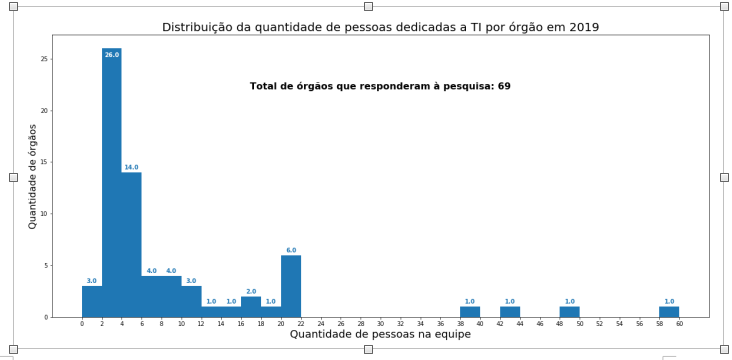

In [44]:
from IPython.display import Image
path_grafico = os.path.join('original_data', 'grafico_q7.png')
Image(filename=path_grafico) 

Primeiro vamos ver se conseguimos reproduzir o gráfico acima com os dados

In [45]:
df_2019 = df[df['ano_diagnostico']==2019].copy()

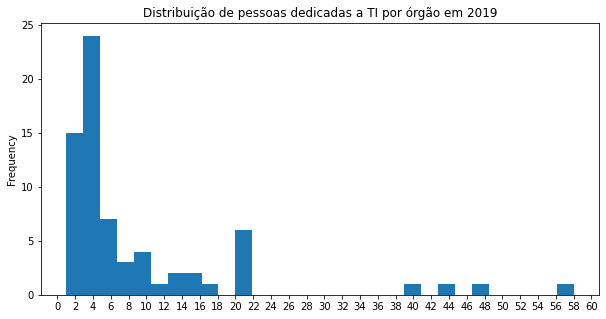

In [46]:
por_orgao = df_2019.groupby('orgao')['qtd_equipe'].sum()

ax = por_orgao.plot.hist(figsize=(10,5), bins=30,
                    title='Distribuição de pessoas dedicadas a TI por órgão em 2019')
plt.xticks(ticks=range(0,61,2))
plt.show()

In [47]:
texto_questao = 'a) "De acordo com o Diagnóstico de 2019, metade dos órgãos setoriais da prefeitura possui, no máximo, {resp} pessoas trabalhando de forma dedicada à área de TI".'

In [48]:
mediana = por_orgao.median()

In [49]:
mediana

4.0

In [50]:
len(por_orgao[por_orgao<4])/len(por_orgao)

0.42028985507246375

In [51]:
len(por_orgao[por_orgao<=4])/len(por_orgao)

0.5652173913043478

In [52]:
texto_questao.format(resp=mediana)

'a) "De acordo com o Diagnóstico de 2019, metade dos órgãos setoriais da prefeitura possui, no máximo, 4.0 pessoas trabalhando de forma dedicada à área de TI".'